In [1]:
# ML.ai Hackathon 2025 - Starter Notebook

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import joblib
from tqdm import tqdm

# Sklearn tools for model building and evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# ML Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load training data (400 samples)

train_df = pd.read_csv('train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Columns: Id + {train_df.shape[1]-2} gene features + Class")

Training data shape: (400, 14574)
Columns: Id + 14572 gene features + Class


In [4]:
# Load labeled subset (150 samples with known labels)

train_labels_df = pd.read_csv('train_labels.csv')
print(f"Labeled training data shape: {train_labels_df.shape}")

Labeled training data shape: (150, 2)


In [5]:
# Check labeled vs unlabeled samples in train.csv

labeled_count = train_df['Class'].notna().sum()
unlabeled_count = train_df['Class'].isna().sum()
print(f"\nIn train.csv:")
print(f"Labeled samples: {labeled_count}")
print(f"Unlabeled samples: {unlabeled_count}")


In train.csv:
Labeled samples: 150
Unlabeled samples: 250


In [6]:
# Class distribution in labeled data

print(f"\nClass distribution in labeled data:")
print(train_labels_df['Class'].value_counts().sort_index())


Class distribution in labeled data:
Class
0    26
1    26
2    56
3    15
4    27
Name: count, dtype: int64


In [7]:
# Merge labels into train_df for consistency (ensures alignment)
train_df = train_df.drop(columns=['Class'], errors='ignore')
train_df = train_df.merge(train_labels_df, on="Id")

In [8]:
# Extract gene columns and target
gene_cols = [col for col in train_df.columns if col.startswith("gene_")]
X = train_df[gene_cols]
y = train_df["Class"]

In [ ]:
# Data Preprocessing
# Real-world biological data(any real world data) often have missing values due to failed reads or sequencing artifacts.
# We'll impute these with the column mean using SimpleImputer.
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

In [10]:
# Pre-process data
# Gene expression values can vary widely in scale.
# StandardScaler ensures all features have 0 mean and unit variance — important for distance-based or regularized models.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
# Pre-process data
# High-dimensional data can lead to overfitting. Feature selection helps.
# We use SelectKBest with mutual_info_classif, a non-linear method capturing dependencies better than correlation.
# also because co relation may takes more time in huge data set (may be I'm not sure...~~~);
selector = SelectKBest(mutual_info_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [gene_cols[i] for i in selector.get_support(indices=True)]

print(f"Selected top {len(selected_features)} gene features.")

Selected top 50 gene features.


In [ ]:
# Define Models and Setup Stratified K-Fold
# StratifiedKFold preserves class distribution in folds, which is crucial in imbalanced datasets like medical data.
# it also insures proper distribution of all types in all sets .....!!!
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We compare three strong baseline models (cause at time i can only recall three!!): 
# - LightGBM: Fast, efficient on high-dim tabular data
# - XGBoost: Powerful boosting method, often good default
# - RandomForest: Robust, non-parametric, handles noise well
models = {
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
}

results = {}


🚀 Training LightGBM


LightGBM CV:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 50
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Program Files\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM CV:  20%|██        | 1/5 [00:00<00:01,  2.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM CV:  40%|████      | 2/5 [00:00<00:01,  2.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 50
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM CV:  60%|██████    | 3/5 [00:01<00:00,  3.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM CV:  80%|████████  | 4/5 [00:01<00:00,  3.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


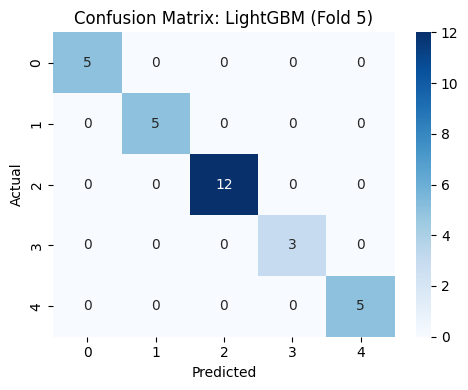

LightGBM CV: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


✅ LightGBM Average F1 (macro): 0.9829

🚀 Training XGBoost


XGBoost CV:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [05:22:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost CV:  20%|██        | 1/5 [00:00<00:03,  1.05it/s]C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [05:22:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost CV:  40%|████      | 2/5 [00:01<00:01,  1.89it/s]C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [05:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost C

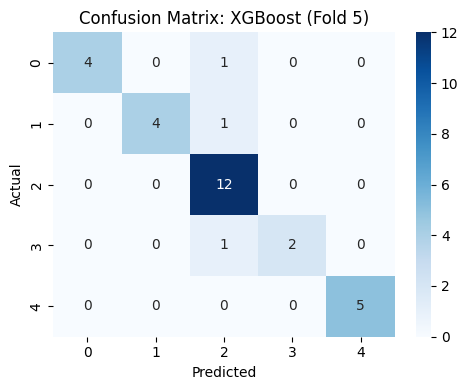

XGBoost CV: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


✅ XGBoost Average F1 (macro): 0.9507

🚀 Training RandomForest


RandomForest CV:  80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

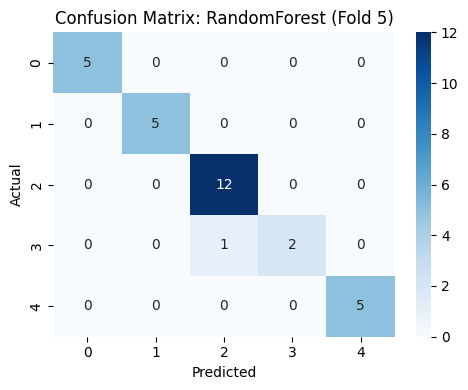

RandomForest CV: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

✅ RandomForest Average F1 (macro): 0.9782


In [ ]:
# Cross-validation for each model
for name, model in models.items():
    print(f"\n🚀 Training {name}")
    fold_f1s = []

    for fold, (train_idx, val_idx) in tqdm( # to show progress bar in console 🔥
        enumerate(cv.split(X_selected, y)),
        total=cv.get_n_splits(),
        desc=f"{name} CV"
    ):
        X_tr, X_val = X_selected[train_idx], X_selected[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model on training fold
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        # F1-macro is a good metric for imbalanced multiclass problems
        f1 = f1_score(y_val, preds, average='macro')
        fold_f1s.append(f1)

        # Confusion matrix helps visualize where model confuses classes
        if fold == cv.get_n_splits() - 1:
            plt.figure(figsize=(5, 4))
            cm = confusion_matrix(y_val, preds)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"Confusion Matrix: {name} (Fold {fold+1})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.savefig(f"conf_matrix_{name}.png")
            plt.show()

    avg_f1 = np.mean(fold_f1s)
    results[name] = avg_f1
    print(f"✅ {name} Average F1 (macro): {avg_f1:.4f}")

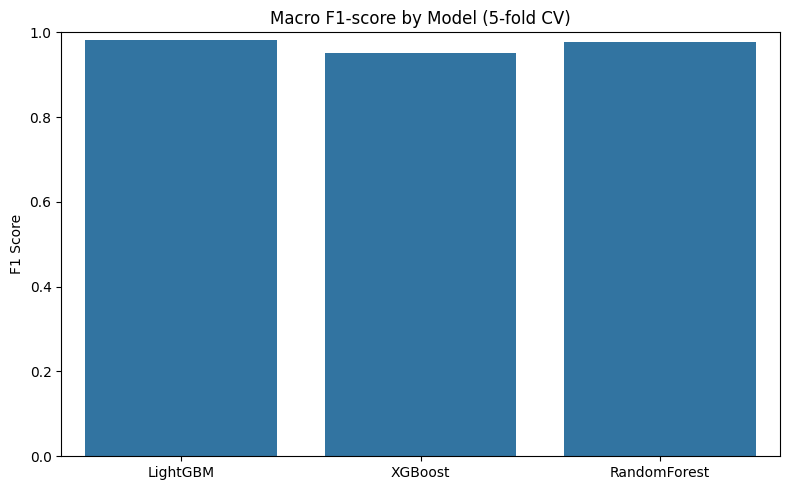

In [ ]:
# Plot comparison of models' cross-validation scores
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Macro F1-score by Model (5-fold CV)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()

In [ ]:
# After comparison, retrain the best model on entire training data for final prediction
best_model_name = max(results, key=results.get)
final_model = models[best_model_name]
final_model.fit(X_selected, y)
print(f"\n🏆 Best model selected: {best_model_name}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 50
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
# Save Model and Preprocessing Pipeline // not necessary ;my computer was slow thats why i saved it for future
joblib.dump(final_model, "final_model.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "feature_selector.pkl")
pd.Series(selected_features).to_csv("selected_features.txt", index=False)

In [17]:
# Load test data (401 samples for prediction)

test_df = pd.read_csv('test.csv') 
print(f"Test data shape: {test_df.shape}")
print(f"Columns: Id + {test_df.shape[1]-1} gene features")

Test data shape: (401, 14573)
Columns: Id + 14572 gene features


In [18]:
# Extract gene features (all columns except Id and Class)

gene_cols = [col for col in train_df.columns if col.startswith('gene_')]
print(f"\nNumber of gene features: {len(gene_cols)}")


Number of gene features: 14572


In [19]:
# Prepare test data
X_test = test_df[gene_cols]
test_ids = test_df['Id']

print(f"Test features shape: {X_test.shape}")
print(f"Test IDs shape: {test_ids.shape}")


Test features shape: (401, 14572)
Test IDs shape: (401,)


In [20]:
# TODO : Train your Model for making predictions on test data
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_selected = selector.transform(X_test_scaled)

In [21]:
# TODO : Generate predictions using your trained model
predictions = final_model.predict(X_test_selected)

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
submission = pd.DataFrame({
    'Id': test_ids,
    'Class': predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created!")
print(f"Submission shape: {submission.shape}")
print(submission.head())


Submission file created!
Submission shape: (401, 2)
           Id  Class
0  sample_313      2
1  sample_427      0
2  sample_573      3
3  sample_214      1
4  sample_793      0


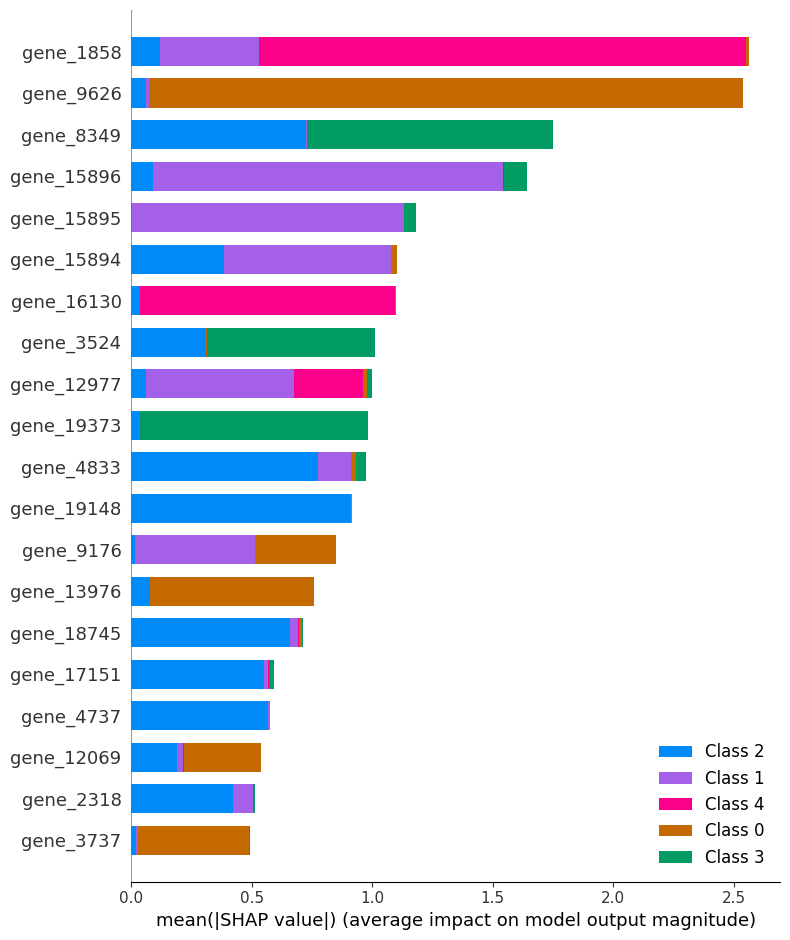

In [ ]:
# SHAP Summary Plot (Feature Importance) to see which feature was more important in final result(modal)
explainer = shap.Explainer(final_model, X_selected)
shap_values = explainer(X_selected)
shap.summary_plot(shap_values, features=X_selected, feature_names=selected_features, show=False)
plt.savefig("shap_summary.png")
plt.show()